In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from tensorflow_docs.vis import embed
import imageio

In [4]:
# 데이터 경로
data_path = "/content/drive/MyDrive/딥러닝프로젝트_1조/UCF101/"

In [6]:
# 학습한 VGG16 모델 읽기 
model = keras.models.load_model(data_path+"vgg16_train1.h5")

In [7]:
# 모델 정보 조회
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 7,898,883
Non-trainable params: 13,239,360
_________________________________________________________________


In [8]:
# 테스트 비디오 파일명과 종류 리턴
test_df = pd.read_csv(data_path+"test.csv")

In [9]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
test_df["label"] = test_df["tag"]

In [10]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
test_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [11]:
text_label = test_df["label"].unique()

In [12]:
text_label

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [13]:
# enumerate(test_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(test_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    test_df["label"].replace(data, index, inplace=True) 

In [14]:
# sklearn.utils.shuffle(test_df) : test_df에 저장된 행을 섞음
test_df=sklearn.utils.shuffle(test_df)

In [15]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 25

In [16]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [17]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=25, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [18]:
# video 파일명 리턴
test_df["video_name"].loc[0]

'v_CricketShot_g01_c01.avi'

In [19]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"test/"+test_df["video_name"].loc[0])

In [20]:
test_df["label"].values.reshape(-1,1)

array([[2],
       [0],
       [2],
       [2],
       [2],
       [1],
       [0],
       [0],
       [2],
       [0],
       [1],
       [1],
       [2],
       [2],
       [0],
       [2],
       [1],
       [2],
       [2],
       [2],
       [0],
       [2],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [2],
       [2],
       [1],
       [2],
       [0],
       [0],
       [2],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [1],
       [2],
       [2],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [2],
       [2],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [2],
       [1],
       [2],
       [2],
       [0],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [21]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [22]:
X_test, y_test = prepare_all_videos(test_df["video_name"], test_df["label"] , data_path + "test/")

In [23]:
X_test.shape

(3425, 224, 224, 3)

In [24]:
y_test.shape

(3425, 3)

In [25]:
X_test[0].shape

(224, 224, 3)

In [26]:
# 이미지 테스트 cost와 정확도 리턴
# batch_size = 64 : 한번에 64개씩 테스트 해서 cost와 정확도의 평균을 계산
model.evaluate(
    X_test/255, y_test, batch_size = 64
)

54/54 [==============================] - 45s 597ms/step - loss: 0.0463 - acc: 0.9825


[0.04632304236292839, 0.9824817776679993]

In [27]:
# 이미지 종류 조회
text_label

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

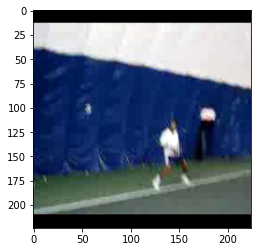

In [28]:
# 0번째이미지
plt.imshow(X_test[0]/255)

In [29]:
# 0번째 이미지
frame = X_test[0:1]
# 이미지의 종류 예측
predict01 = model.predict(frame/255)
print("predict01 = ", predict01)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
print("predict02 = ", predict02)
# 이미지의 종류 조회
text_predict = text_label[predict02]
print("text_predict=", text_predict)

predict01 =  [[1.6010159e-01 3.1496011e-04 8.3958346e-01]]
predict02 =  [2]
text_predict= ['TennisSwing']


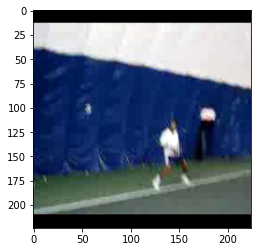

In [30]:
# 0번째 이미지 image에 대입
image = frame[0].copy()
plt.imshow(image/255)

In [31]:
# 이미지의 종류
str = "Activity :{}".format(text_predict)
# str을 출력할 이미지 좌표
org=(0,20) 
# 이미지 폰트
font=cv2.FONT_HERSHEY_PLAIN
# image에 str을 출력
cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

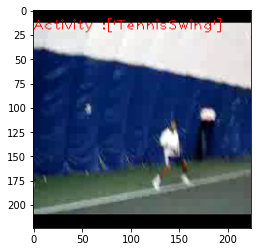

In [32]:
# image에 str (영상 종류 예측값 ) 출력
plt.imshow(image/255)

In [33]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(25,224,224,3))

for i in range(25):
    # X_test의 i번째 이미지
    frame = X_test[i:i+1]
    # 이미지의 종류 예측
    predict01 = model.predict(frame/255)
    # 최고값이 있는 인덱스 조회
    predict02 = np.argmax(predict01, axis=1)
    # 이미지의 종류 조회
    text_predict = text_label[predict02]
    # 이미지의 종류
    str = "Activity :{}".format(text_predict)
    print("str = ", str)
    # frame을 복사
    image = frame[0].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을 출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image

str =  Activity :['TennisSwing']
str =  Activity :['CricketShot']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']
str =  Activity :['TennisSwing']



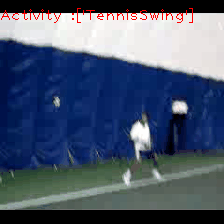

In [34]:
# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=25)
# animation.gif 를 출력
embed.embed_file("animation.gif")